In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.signal import lfilter, firls, decimate
from tqdm import tqdm_notebook as tqdm
from easydict import EasyDict as edict
from collections import Counter
import pickle

In [3]:
resDir = Path("../results")
dataDir = Path("../data")

filname = Path("fMRI_samples.mat")
fMRIs = loadmat(dataDir/filname)["clean_subjects"]

In [4]:
fs = 0.5 #sampling frequency
fmin = 0.009 # 
fmax = 0.08
hbp = firls(21, np.array([0, 0.009, 0.01, 0.08, 0.09, 0.8]), #0.8
           desired = np.array([0, 0, 1, 1, 0, 0]))

num = fMRIs.shape[-1]
fMRIsHPF = []
for i in range(num):
    cfMRI = fMRIs[0, i]["fMRI"][:90, :]
    # detrend
    cfMRI = detrend(cfMRI)
    chpffMRI = lfilter(hbp, 1, cfMRI)
    fMRIsHPF.append(chpffMRI[:, 25:])

In [6]:
Ymat = fMRIsHPF[0]
Ymat.shape

(90, 155)

## Select the kappa with multiple subseqs

- select the subseqs by region

In [7]:
saveDir = resDir/"fMRIHPFs_partregion"
if not saveDir.exists():
    saveDir.mkdir()

    
Lmin = 4
lamb = 8e-5
kappas = np.arange(1, 4, 0.01)

numChgsAll = []
DetObjs = []
for ii in tqdm(range(243)):
    Ymat = fMRIsHPF[ii]
    DetRec = TVDNDetect(Ymat=Ymat, dataType="fMRI", MaxM=20, is_detrend=False,
                      saveDir=None, showProgress=False, Lmin=Lmin, lamb=lamb, kappa=2, r=None)
    DetRec()
    DetRec.TuningKappa(kappas)
    
    DetObjs.append(DetRec)
    
    numChgsSingle = []
    for i in range(5):
        subYmat = Ymat[i::5, :]
        DetRec = TVDNDetect(Ymat=subYmat, dataType="fMRI", MaxM=20, is_detrend=False,
                           saveDir=None, showProgress=False, Lmin=Lmin, lamb=lamb, kappa=2, r=None)
        DetRec()
        DetRec.TuningKappa(kappas)
        numChgsSingle.append(DetRec.numchgs)
        
    numChgsAll.append(numChgsSingle)
    

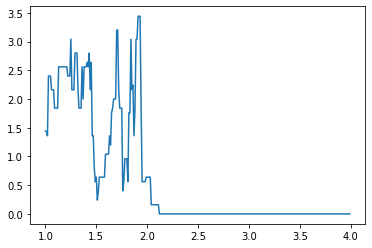

In [22]:
# Find the suitable position
numChgs = numChgsAll[1]
numChgsArr = np.array(numChgs)
varsAll = np.var(numChgsArr, axis=0)
plt.plot(kappas, varsAll)

In [17]:
def kpDet(numChgs, kappas, kpLim=[1.3, 2]):
    numChgsArr = np.array(numChgs)
    varsAll = np.var(numChgsArr, axis=0)
    lowb, upb = kpLim
    kpidxs = ((kappas >= lowb).astype(np.int) + (kappas<=upb)) == 2
    subVarsAll = varsAll[kpidxs]
    subKappas = kappas[kpidxs]
    
    optKpIdx = np.argmin(subVarsAll)
    optKp = subKappas[optKpIdx]
    return optKp

In [23]:
optKps = []
for i in range(243):
    optKps.append(kpDet(numChgsAll[i], kappas))

### Update the kappa

In [26]:
for optKp, DetObj in zip(optKps, DetObjs):
    DetObj.UpdateEcpts(DetObj.numchgs[kappas==optKp][0])

In [29]:
results = {}
results["DetObjs"] = DetObjs
results["optKps"] = optKps
with open(saveDir/"fMRIResultAdapPartRegion.pkl", "wb") as f:
    pickle.dump(results, f)
    
with open(saveDir/"fMRIResultAdapPartRegion.pkl", "rb") as f:
    results = pickle.load(f)
DetObjs = results["DetObjs"]

### num of changes

In [49]:
numChgsOpt = [len(DetObj.ecpts) for DetObj in DetObjs]
numChgsH = numChgsOpt[:103]
numChgsD = numChgsOpt[103:]

<BarContainer object of 9 artists>

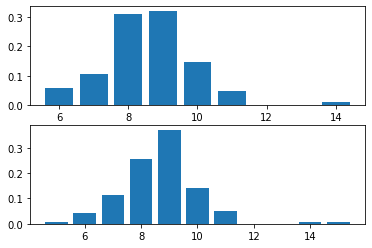

In [56]:
from collections import Counter
ctH = Counter(numChgsH)
ctD = Counter(numChgsD)

Hidxs = sorted(ctH.keys())
Hs = [ctH[i] for i in Hidxs]

Didxs = sorted(ctD.keys())
Ds = [ctD[i] for i in Didxs]


plt.subplot(211)
plt.bar(Hidxs, np.array(Hs)/len(numChgsH))
plt.subplot(212)
plt.bar(Didxs, np.array(Ds)/len(numChgsD))

In [32]:
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn import metrics

Ys = np.concatenate([np.ones(103), np.zeros(140)])
numChgsOpt = np.array(numChgsOpt).reshape(-1, 1)
clf = LogReg(solver='lbfgs').fit(numChgsOpt, Ys)
pred_probs = clf.predict_proba(numChgsOpt)[:, 1]
fpr, tpr, thres = metrics.roc_curve(Ys, pred_probs)
auc = metrics.auc(fpr, tpr)
print(auc)

0.5192787794729542


<BarContainer object of 4 artists>

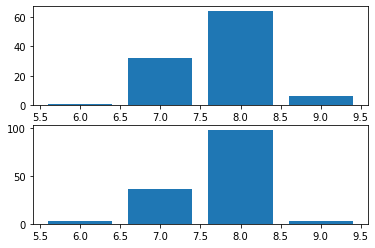

In [51]:
numRks = [DetObj.paras.r for DetObj in DetObjs]
numRkH = numRks[:103]
numRkD = numRks[103:]

ctRkH = Counter(numRkH)
ctRkD = Counter(numRkD)

HRkidxs = sorted(ctRkH.keys())
HRks = [ctRkH[i] for i in HRkidxs]

DRkidxs = sorted(ctRkD.keys())
DRks = [ctRkD[i] for i in DRkidxs]


plt.subplot(211)
plt.bar(HRkidxs, HRks)
plt.subplot(212)
plt.bar(DRkidxs, DRks)

In [55]:
Ys = np.concatenate([np.ones(103), np.zeros(140)])
Xs = np.array([numChgsOpt, numRks]).T
clf = LogReg(solver='lbfgs').fit(Xs, Ys)
pred_probs = clf.predict_proba(Xs)[:, 1]
fpr, tpr, thres = metrics.roc_curve(Ys, pred_probs)
auc = metrics.auc(fpr, tpr)
print(auc)

0.5244798890429958


### Save the results

In [58]:
dics = []
for DetObj in DetObjs:
    cDic = {}
    r = DetObj.paras.r
    rUs = DetObj.midRes.eigVecs[:, :r]
    cDic["eigVals"] = DetObj.RecResCur.LamMs
    cDic["Us"] = rUs
    dics.append(cDic) 
with open(saveDir/"partregion_all_eigvals_vecs.pkl", "wb") as f:
    pickle.dump(dics, f)